## Data Exploration
First, we take a good long look at the data, because it's fun and sometimes useful even! I used [this page](https://jmetzen.github.io/2015-01-29/ml_advice.html) to guide the exploration.


In [1]:
import matplotlib.pyplot as plt
# We tell matplotlib (the plotting library) to render stuff in the notebook, not in a separae window
%matplotlib inline

import pandas as pd

# Seaborn is useful for visualizing things
# http://stanford.edu/~mwaskom/software/seaborn/
import seaborn as sns
sns.set(style="ticks", color_codes=True)

import kinecture

In [2]:
# When we make changes to modules, automatically reload the modules
%load_ext autoreload
%autoreload 2

In [91]:
# load data
xls = pd.ExcelFile('data/allData-filtered.xlsx')
train_dataframe = xls.parse('filtered-noFormulas')

print("number of train instances:", len(train_dataframe))

number of train instances: 8906


There are 3 labels we need to classify:

Label | Description
--|--
S | Student
TA | TA
SI | Silent

Furthermore, it looks like there are more of one label than another:

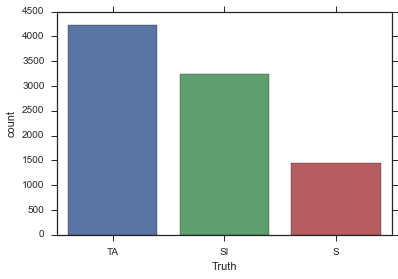

In [68]:
_ = sns.countplot(x="Truth", data=train_dataframe)

Also, it looks like there are more datapoints from session 10:

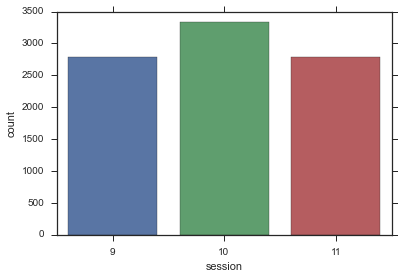

In [69]:
_ = sns.countplot(x="session", data=train_dataframe)

And, in some sessions (namely session 11), there was much less silence:

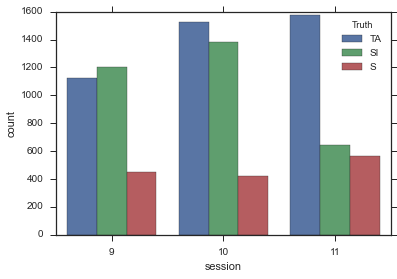

In [4]:
_ = sns.countplot(x="session", hue="Truth", data=train_dataframe)

Our baseline uses a heuristic algorithm. Overall the heuristic algorithm does poorly in determining student state (13% precision). In most cases students are classified as silent (971/1475 instances are silent). Determining TA state is also low (67% accuracy), again much confusion with silent state (1342/4331 are silent). Seems like we are overfitting to silent, even though there are more TA instances in the training set.

### Generating features
I looked at the data from a previous pass, and added a few more features. Here they are. Afterward I print out all the features I have, which will be useful later

In [96]:
train_dataframe = kinecture.clean_data(train_dataframe)
train_dataframe = kinecture.gen_features(train_dataframe)

### Visualization the distribution of features
One of my favorite things to do is to see how different features are distributed, and correlated with each other. That's because this is the point where I get to make pretty pictures that sometimes give insight into the data!

In [81]:
train_features = train_dataframe.copy()
del train_features['Truth']

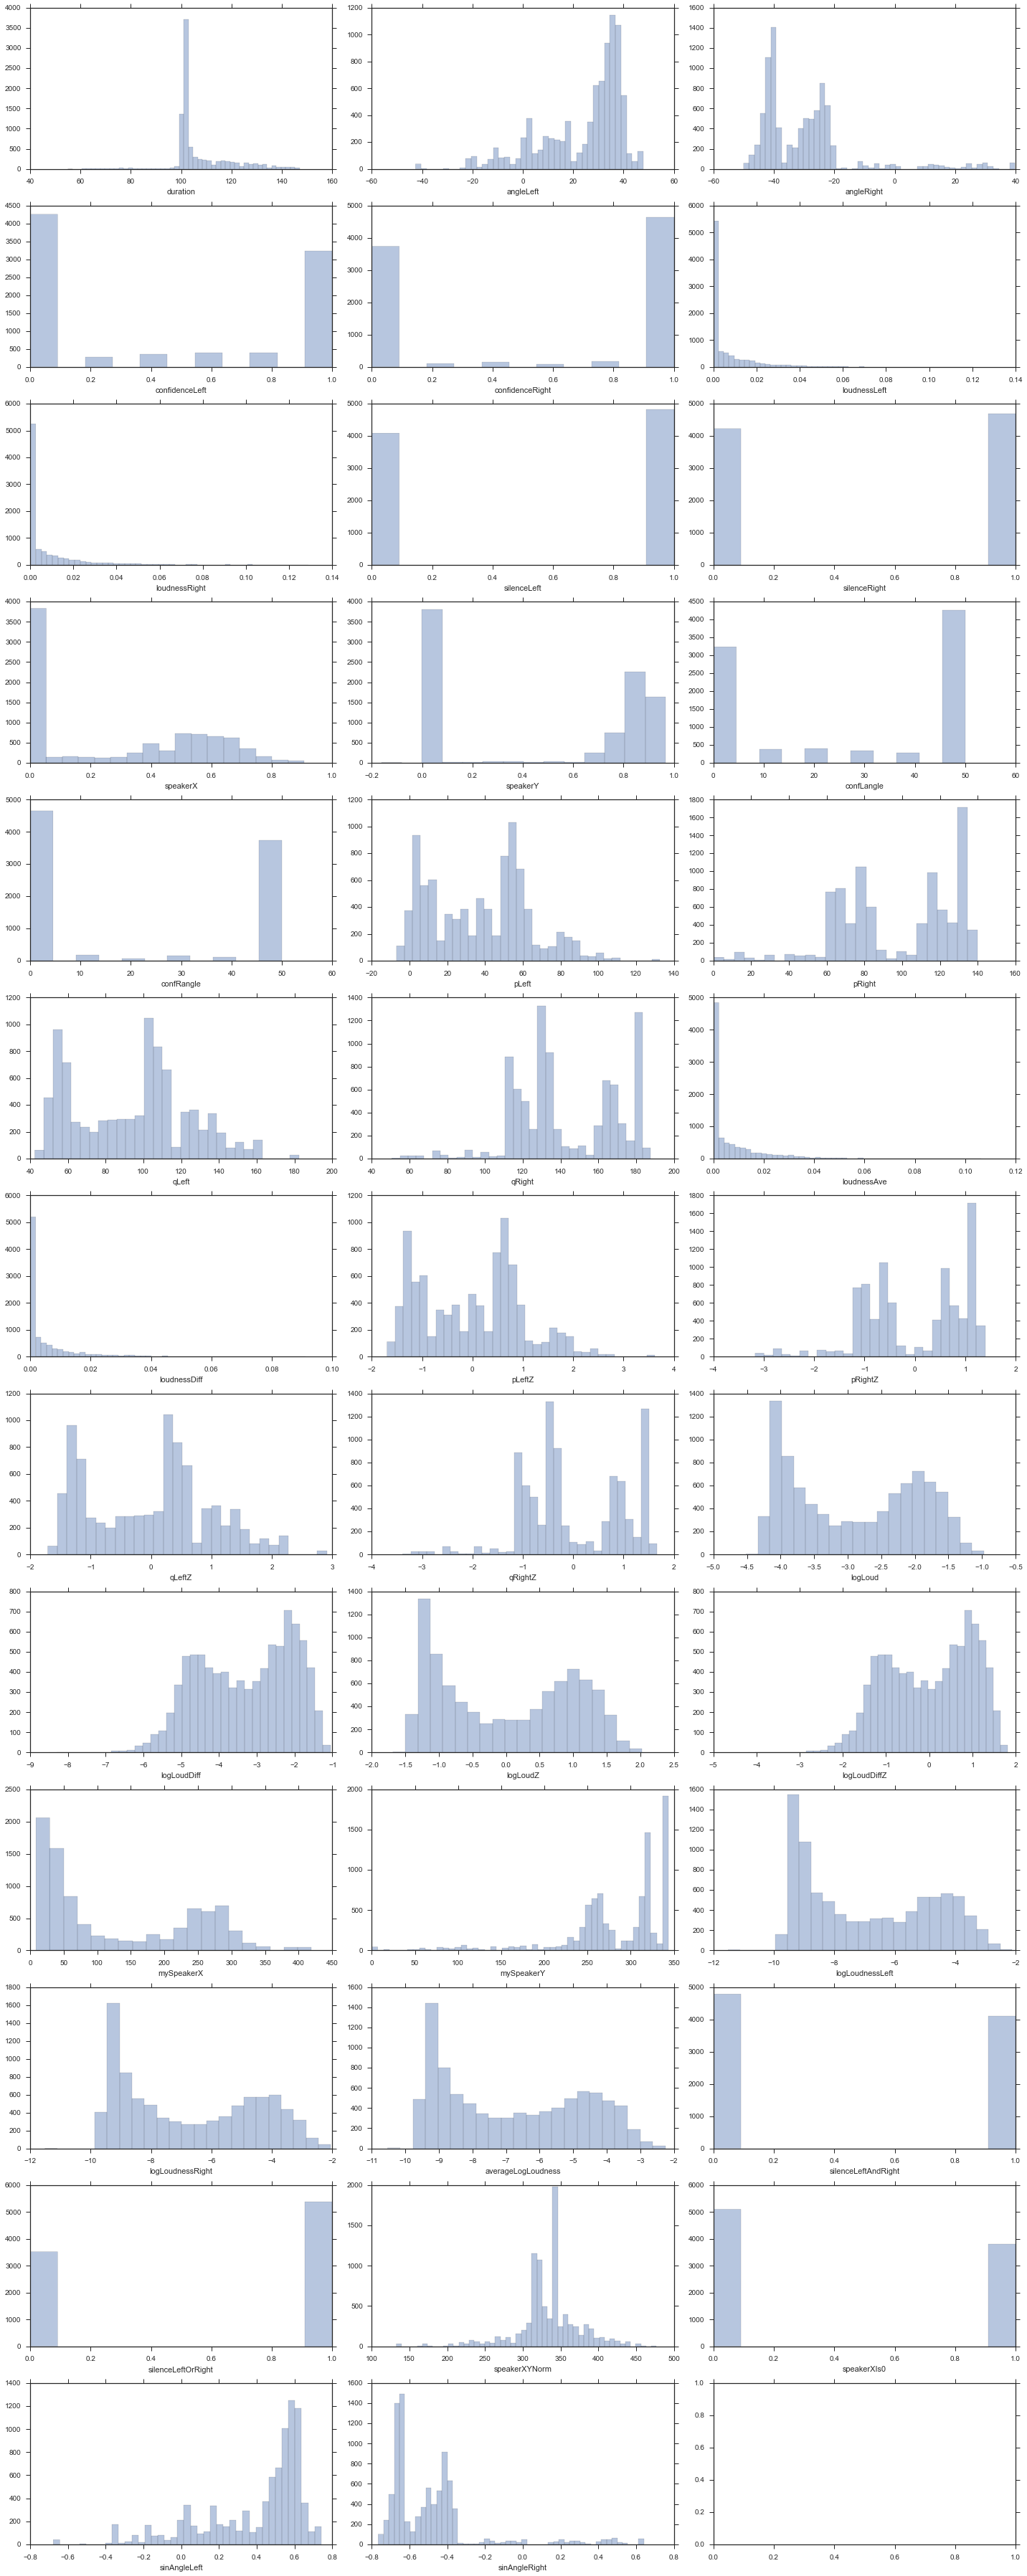

In [93]:
kinecture.plot_distributions(train_features, train_features.columns, 3)

#### Observations
* logLoud and logLoudZ have almost the same distribution, not surprisingl logLoudZ probably not that useful...
* logLoudnessLeft and logLoudnessRight have same distribution as logLoud, probably can just use logLoud 
* confidenceLeft and confidenceRight are very bimodal
* speakerX and speakerY have a large number of instances that are 0 (3,929). Furthermore, speakerX is 0 when speakerY is 0. Seems like the value indicates some sort of invalid data. Indicates that we may want to use a different classifier when speakerX is 0 ("ensemble method")

### Visualize correlations Between features
Another technique I like to give me an idea of the kind of classifier to use: draw scatterplots and histograms to see if any one or two variables look like they can separate the data:

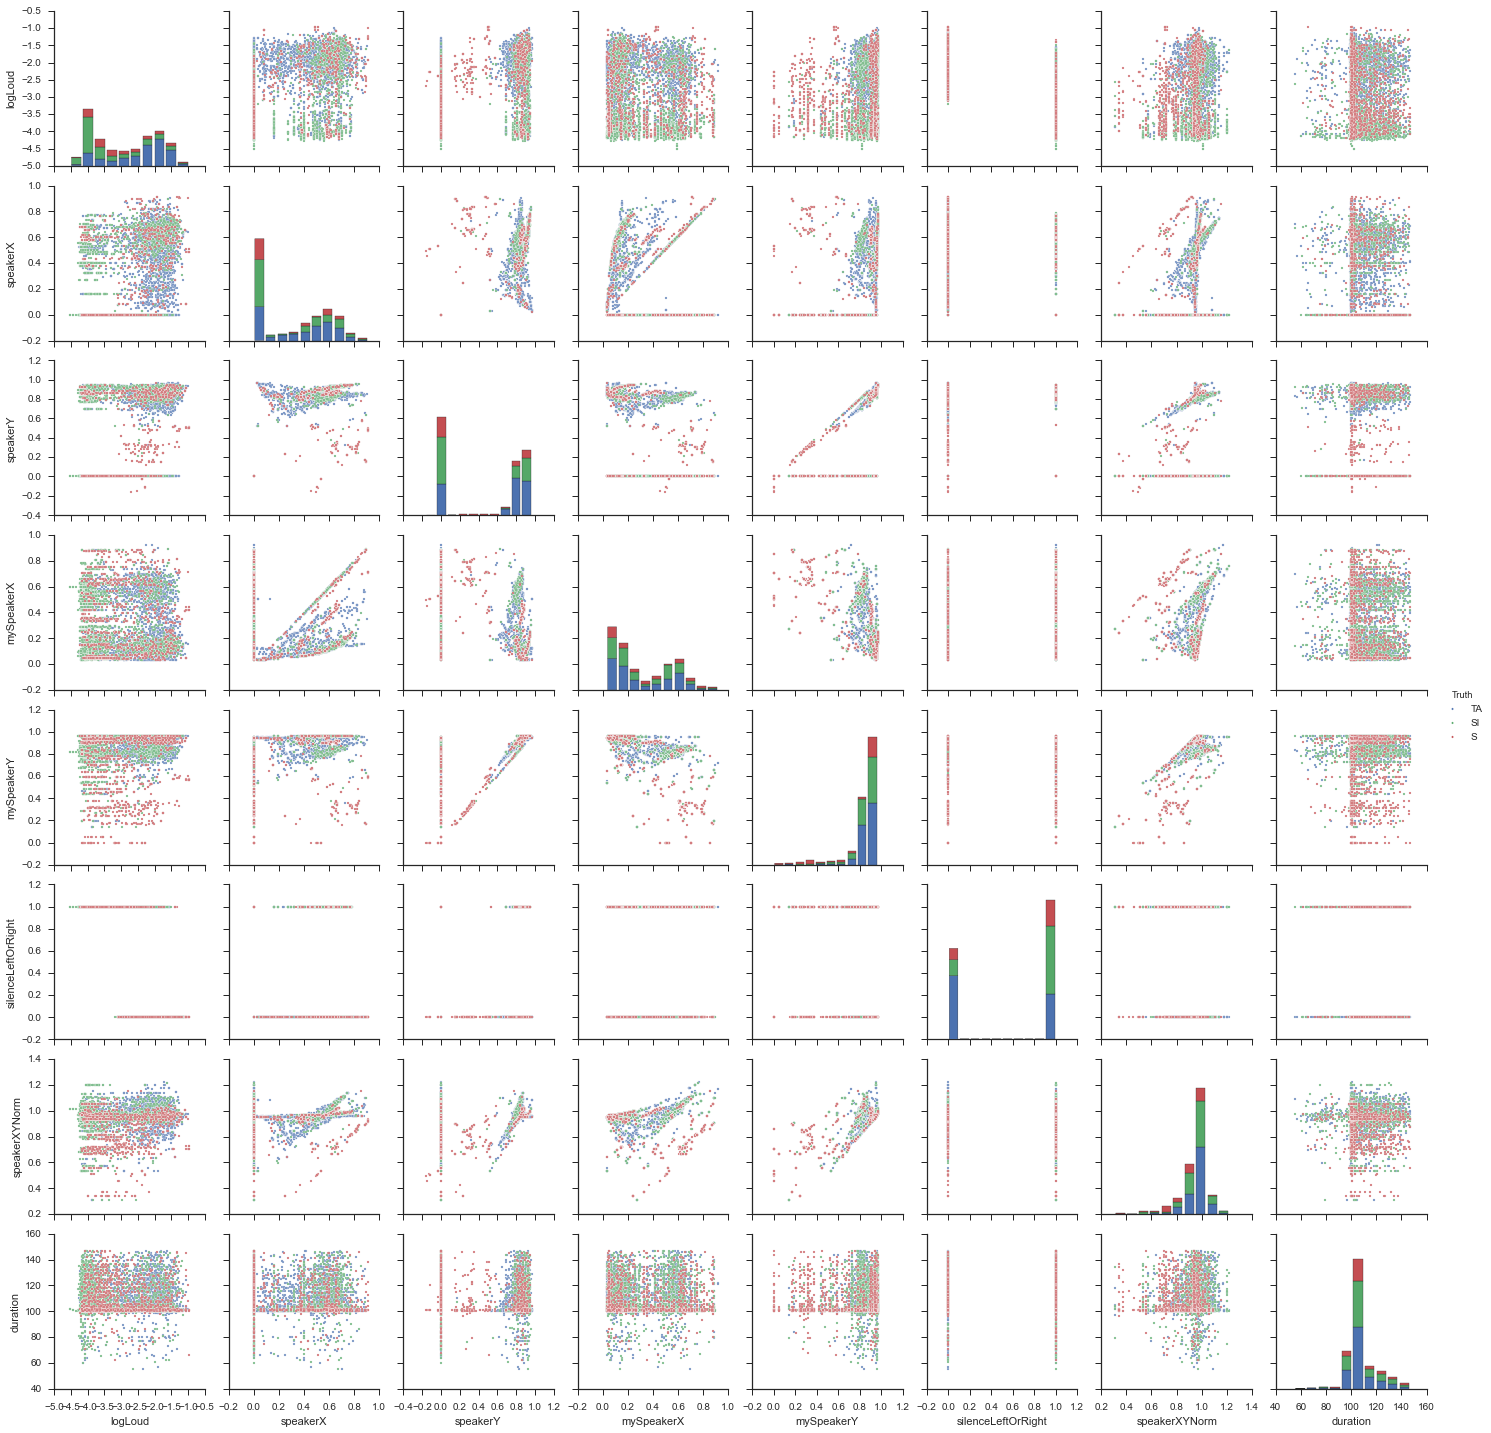

In [98]:
g = sns.pairplot(train_dataframe,
                 markers='.', # use 'o' for a larger dot
                 vars=["logLoud", 
                       "speakerX", 
                       "speakerY",
                       "mySpeakerX",
                       "mySpeakerY",
                       "silenceLeftOrRight",
                       "speakerXYNorm",
                       "duration"],
                 hue="Truth")

#### Observations
* Several features seem to do a decent job of determining silent: silenceLeftRight, also speakerX. However, it's unlikely that a single variable would get the accuracies you need.
* silenceLeft and silenctRight actually do a decent job of separating quiet data, however they are highly correlated. Created new silentLeftAndRight, silentLeftOrRight in case those did any better. These are also highly correlated.
* Silent data has more logLoud near low values (not surprising)
* Many more instances seem to be above 100 duration, I see a sharp division. Furthermore, very few instances are silent below that value. Duration might be a good feature.

Overall, it looks like this data might be separable, but the separation looks nonlinear, at least in two variables. Quadratic or RBF kernel in SVM could work well.


### More Correlation: Are session, duration, and loudness related?
I was wondering if some sessions were louder than others, so I made some more pairplots:

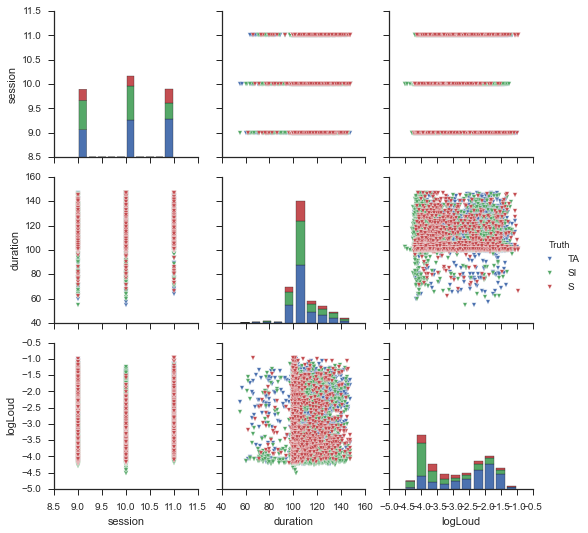

In [55]:
g = sns.pairplot(train,
                 markers='v', # use 'o' for a larger dot
                 vars=["session", 
                       "duration", 
                       "logLoud"],
                 hue="Truth")

#### Observations
* Some durations are much longer than others. In all cases these were students. Looks like possibly outliers.
* Loudness doesn't seem that different. Several long durations in session 9. Looks like an outlier honestly...


### More Correlation: Are confidence and loudness related?
One more set of pairplots to see if those two were correlated:

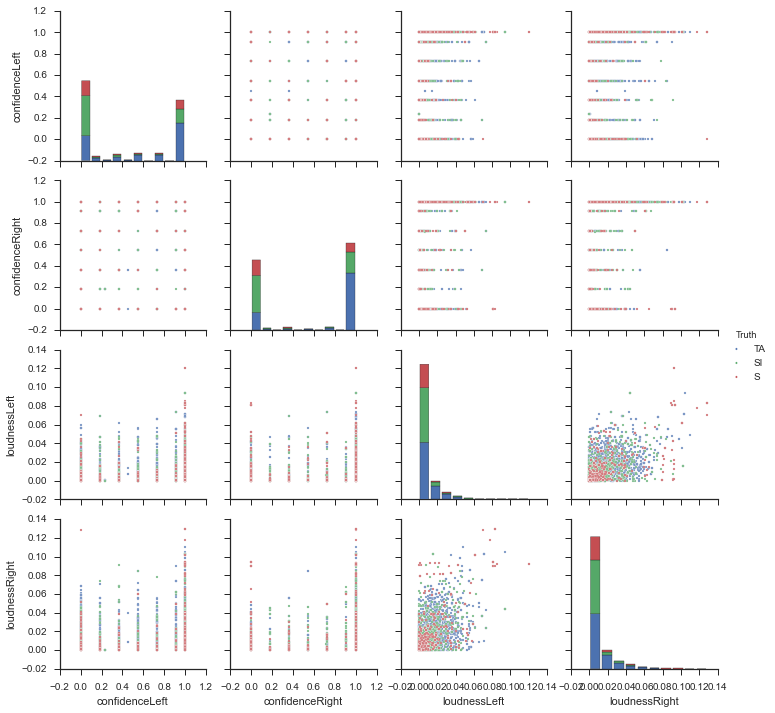

In [100]:
g = sns.pairplot(train_dataframe,
                 markers='.', # use 'o' for a larger dot
                 vars=["confidenceLeft", 
                       "confidenceRight", 
                       "loudnessLeft",
                       "loudnessRight"],
                 hue="Truth")

#### Observations
* Confidence is very bimodal
* Not much correlation between loudness and confidence
* Most of data is pretty quiet, but when left is loud right tends to be loud as well

### Massive Correlation Matrix
Okay, enough with these individual correlation experiments, let's see which variables are correlated just for fun:

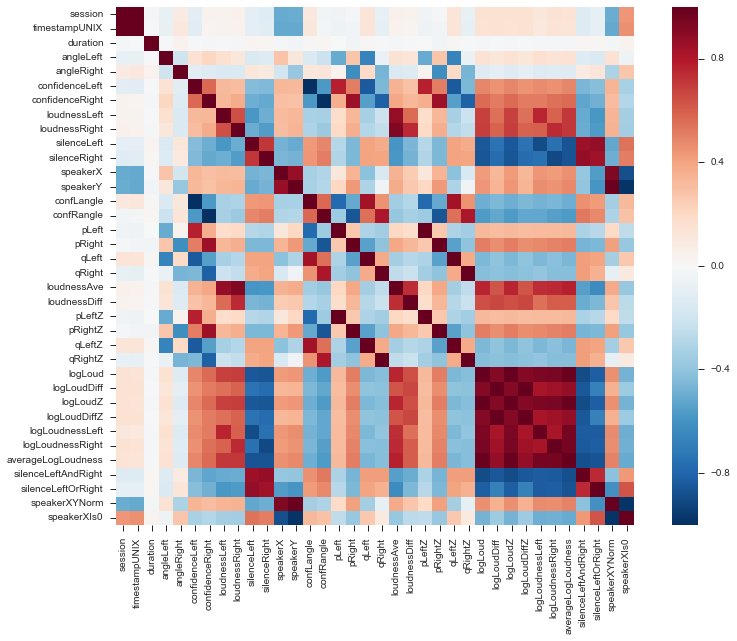

In [57]:
# Get correlations between variables
# source: http://stanford.edu/~mwaskom/software/seaborn/examples/network_correlations.html?highlight=heatmap
correlation_matrix = train_dataframe.corr()
fig, axes = plt.subplots(1,1, figsize=(12,9))
sns.heatmap(correlation_matrix, vmax=0.8, square=True)
fig.tight_layout()


#### Observations
* I was wondering ig speakerXIs0 correlated perfectly with any other variables, so I could understand why so much data had speakerX as 0. But, I didn't find anything

### Time series Visualization
I had forgotten that the data is actually time series! Just wondering what the data (especially speakerX, speakerY) looks like.

In [61]:
label_map = {label:idx for (idx, label) in enumerate(["S", "SI", "TA"])}
train_features['Truth_idx'] = [label_map[truth] for truth in train_dataframe['Truth']]

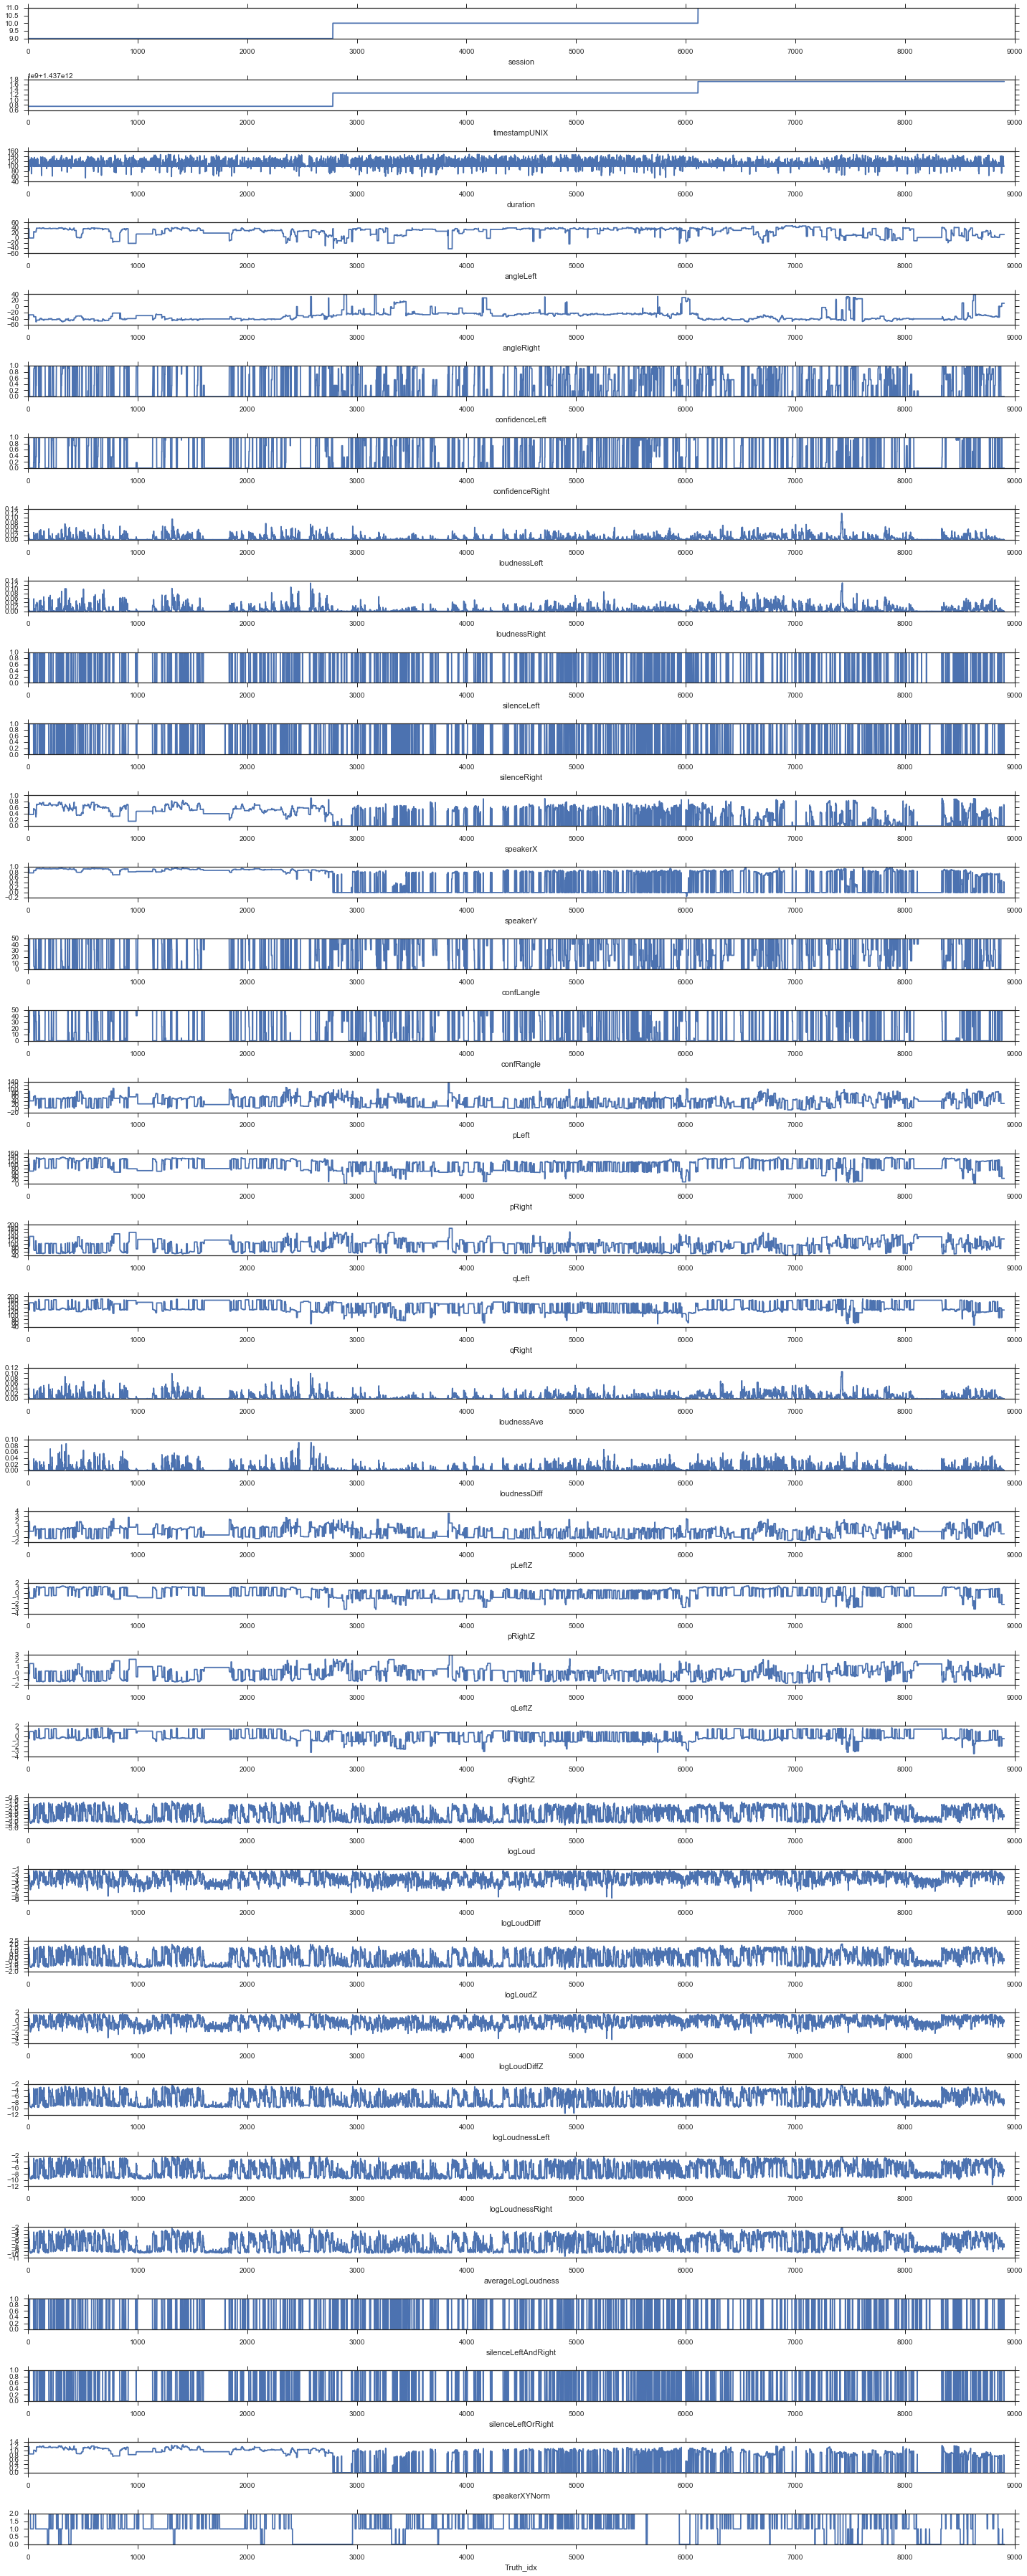

In [62]:
kinecture.plot_timeseries(train_features, train_features.columns, 1)

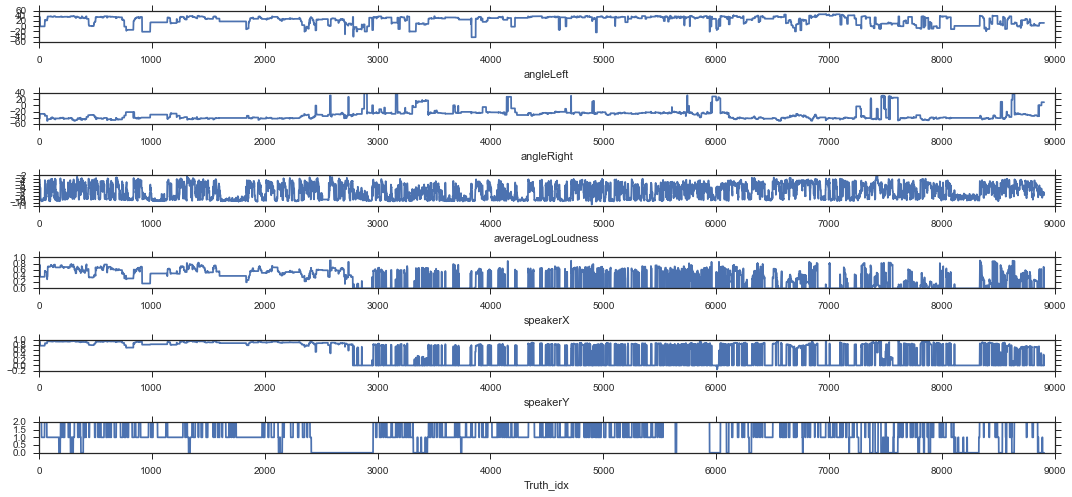

In [63]:
kinecture.plot_timeseries(train_features, ['angleLeft', 'angleRight', 'averageLogLoudness', 'speakerX', 'speakerY', 'Truth_idx'], 1, figsize=(15, 7))